<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista10 - BERT
**Nome: Felipe de Lima Peressim** 

**Numero Usp: 11823558** 









______________




O objetivo desta lista é fazer com que vocês se familiarizem com o BERT por meio da biblioteca HuggingFace. Novamente, as questões 1 2 e 3 podem ser copiadas de listas anteriores.

In [9]:
#!pip install transformers

In [10]:
#!nvidia-smi

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments,
)
from sklearn.model_selection import train_test_split

### Importando os dados como um dataframe

Para esta lista nós utilizaremos o dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [2]:
b2wCorpus = pd.read_csv("https://raw.githubusercontent.com/abarbosa94/NLPortugues/master/Semana%2009/data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [3]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object


### Pré-processamento
Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar. 
Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

In [4]:
b2wCorpus["reviewer_gender"].value_counts()

M                                                                         5033
F                                                                         4624
                                                                             1
Ocorrência: Z-Devolução Em Andamento Ao Cd de São Paulo 22/12/17 16:12       1
1970                                                                         1
Name: reviewer_gender, dtype: int64

## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend". 

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [5]:
b2wCorpus['recommend_to_a_friend'] = b2wCorpus['recommend_to_a_friend'].apply(lambda word : 1 if str(word).lower() == 'yes' else 0)
x = b2wCorpus['review_text'].values.astype('str')
y = b2wCorpus['recommend_to_a_friend'].values

### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do Scikit-Learn como na lista passada.

In [67]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

### Tokenizando

Para aplicar o processo de _Tokenize_ dos nossos dados, diferente das listas anteriores, utilizaremos a classe [BertTokenizer](https://huggingface.co/transformers/master/model_doc/bert.html#berttokenizer) da biblioteca [transformers](https://github.com/huggingface/transformers) do HuggingFace.

Para isso, veja o exemplo abaixo:


In [8]:
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(REF_MODEL)
text = pd.DataFrame(["isso é um text", "o rato roeu a roupa", "do rei de Roma"])

I1106 16:59:16.090327 139954203100992 filelock.py:274] Lock 139951822711272 acquired on /home/felipe/.cache/torch/transformers/953e203ca70d433ab232eb85ae0093b7fd73a61d7931d54a460a131b5e15b10e.d2f3b3fde3658e304f905ed624bcacd8555c946377121f9211932f66c9fe1202.lock


I1106 16:59:17.464372 139954203100992 filelock.py:318] Lock 139951822711272 released on /home/felipe/.cache/torch/transformers/953e203ca70d433ab232eb85ae0093b7fd73a61d7931d54a460a131b5e15b10e.d2f3b3fde3658e304f905ed624bcacd8555c946377121f9211932f66c9fe1202.lock


I1106 16:59:18.161253 139954203100992 filelock.py:274] Lock 139951822735512 acquired on /home/felipe/.cache/torch/transformers/e763f2a607ad8e4a10a0a8ca9b7e289e8704d9bf24ee520772ee28547721c295.3889713104075cfee9e96090bcdd0dc753733b3db9da20d1dd8b2cd1030536a2.lock


I1106 16:59:19.025109 139954203100992 filelock.py:318] Lock 139951822735512 released on /home/felipe/.cache/torch/transformers/e763f2a607ad8e4a10a0a8ca9b7e289e8704d9bf24ee520772ee28547721c295.3889713104075cfee9e96090bcdd0dc753733b3db9da20d1dd8b2cd1030536a2.lock


I1106 16:59:19.799683 139954203100992 filelock.py:274] Lock 139951822711272 acquired on /home/felipe/.cache/torch/transformers/aa29d58ec2f0278e3ff71ce26a902511a549e75a7596ae790a751253f2950b3d.275045728fbf41c11d3dae08b8742c054377e18d92cc7b72b6351152a99b64e4.lock


I1106 16:59:20.670067 139954203100992 filelock.py:318] Lock 139951822711272 released on /home/felipe/.cache/torch/transformers/aa29d58ec2f0278e3ff71ce26a902511a549e75a7596ae790a751253f2950b3d.275045728fbf41c11d3dae08b8742c054377e18d92cc7b72b6351152a99b64e4.lock


I1106 16:59:21.540782 139954203100992 filelock.py:274] Lock 139951822735400 acquired on /home/felipe/.cache/torch/transformers/316240c7b41ed25c9fc43a68d281f3f84a6efdb7f40cf1e9bd739e859285991b.d3d276ada459b0aec3a25156bf4df869f8362968dd3a7052748ad41fcb496476.lock


I1106 16:59:22.325802 139954203100992 filelock.py:318] Lock 139951822735400 released on /home/felipe/.cache/torch/transformers/316240c7b41ed25c9fc43a68d281f3f84a6efdb7f40cf1e9bd739e859285991b.d3d276ada459b0aec3a25156bf4df869f8362968dd3a7052748ad41fcb496476.lock


In [9]:
SEQ_LEN=5
encoded_text = tokenizer(
    text.values.tolist(),
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQ_LEN,
    pad_to_max_length=True,
    return_tensors='tf'
)
encoded_text_labels = np.array([0,0,1])

In [10]:
encoded_text

{'input_ids': <tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[ 101, 1257,  253,  222,  102],
       [ 101,  146,  646,  183,  102],
       [ 101,  171, 1754,  125,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=int32)>}

Como é possível ver, o resultado gera um dicionário com 3 chaves, representando diferentes tensores:

    - input_ids (os arrays de entrada convertidos para inteiro)
    - token_type_ids (Indicação se pertence a sentença A ou B [0 é sentença A e 1 é sentença B])
    - attention_mask (indicando quais tokens foram mascarados. Como todos os tokens **não** foram mascarados, o valor aqui sempre é 1)

## <font color='blue'>Questão 3 </font>

Aplique o tokenizer nos dados de treino e teste, gerando duas variáveis **encoded_train** e **encoded_test**, considerando o max_length como o tamanho da sentença ideal. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

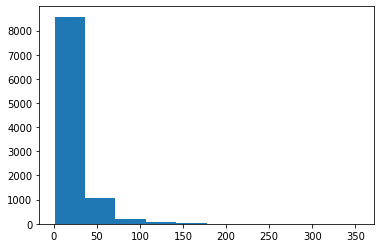

In [26]:
plt.hist([len(linha.split()) for linha in b2wCorpus["review_text"]])
plt.show()

In [11]:
#"bert-base-multilingual-cased"
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(REF_MODEL)

In [125]:
SEQUENCE_MAXLEN = 50

encoded_train = tokenizer(
    [[line] for line in x_train],
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQUENCE_MAXLEN,
    pad_to_max_length=True,
    return_tensors='np'
)

In [126]:
encoded_valid = tokenizer(
   [[line] for line in x_val],
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQUENCE_MAXLEN,
    pad_to_max_length=True,
    return_tensors='np'
)

In [127]:
encoded_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [128]:
encoded_train['input_ids'].shape

(6999, 50)

### Montando o modelo

Para montar o modelo, iremos utilizar a classe TFBertForSequenceClassification, do HuggingFace

Aqui tem um exemplo de código para vocês seguirem!


In [26]:
bert_model = TFBertForSequenceClassification.from_pretrained(REF_MODEL, from_pt=True, num_labels=2)
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='masked_token', dtype='int32')

X = bert_model(input_ids, input_masks_ids)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the P

In [27]:
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 5)]          0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 5)]          0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica ((None, 2),)         108924674   input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 108,924,674
Trainable params: 108,924,674
Non-trainable params: 0
__________________________________________________________________________________________________


In [19]:
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
model.compile(opt, "sparse_categorical_crossentropy", metrics=["acc"])

In [20]:
history = model.fit(
    [encoded_text["input_ids"], encoded_text["attention_mask"]],
    encoded_text_labels,
    batch_size=32,
    epochs=2,
    callbacks=my_callbacks,
)

Epoch 1/2
1/1 [==============================] - ETA: 0s - loss: 2.1274 - acc: 0.6667

W1106 17:21:46.097144 139954203100992 callbacks.py:1689] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


1/1 [==============================] - 0s 48ms/step - loss: 2.1274 - acc: 0.6667
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 0.5341 - acc: 1.0000

W1106 17:21:48.734575 139954203100992 callbacks.py:1689] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


1/1 [==============================] - 0s 46ms/step - loss: 0.5341 - acc: 1.0000


## Treinando e avaliando seu modelo

###  <font color='blue'>Questão 4 </font>

Defina e treine seu modelo.

**Lembre-se de tambem adicionar os dados de validação do modelo**

In [129]:
bert_model = TFBertForSequenceClassification.from_pretrained(REF_MODEL, from_pt=True, num_labels=2)
input_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='masked_token', dtype='int32')

X = bert_model(input_ids, input_masks_ids)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the P

In [130]:
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

In [131]:
opt = tf.keras.optimizers.Adam()
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]
model.compile(opt, "binary_crossentropy", metrics=["acc"])

In [132]:
history = model.fit(
    [encoded_train["input_ids"],
     encoded_train["attention_mask"]],
    y_train,
    batch_size=64,
    epochs=1,
    callbacks=my_callbacks,
    validation_data = ([encoded_valid["input_ids"],
                       encoded_valid["attention_mask"]],
                       y_val)
)    

  2/110 [..............................] - ETA: 16:59 - loss: 7.3940 - acc: 0.2812

KeyboardInterrupt: 